**Summary**

In this code we will implement the TinyML to detect the driver drowsiness

# PreProcessing phase


#### Import Packages

The following packages will be used to implement a basic system in Python. Importing libraries and layers from tensorflow.

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3

DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.


In [ ]:
import os
import zipfile
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import cv2
import dlib
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

#### Mounts Google drive with Google CoLab to import dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/Driver_Drowsiness_Dataset.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/My Drive/driver_drowsiness_dataset/train")

In [ ]:
labels = os.listdir("../train")
labels

['eyes',
 '.ipynb_checkpoints',
 'drowiness_new20.model',
 'models_code1_mask',
 'exp_saved_model',
 'model-optimization',
 'DL_Model_Saved',
 'tflite_qaware_model.tflite',
 'model_tl.tflite',
 'DL_Models_Saved_MobileNet-V3',
 'tf_lite_model.tflite',
 'tf_model_fashion_mnist',
 'tmp',
 'drowiness_new6.model',
 'tf_model_fashion_mnist.h5',
 'drowiness_new20.h5',
 'models1',
 'AlexNetModel_1.hdf5',
 'DL_model_Saved',
 'models',
 'Closed_1',
 'AlexNetModel.hdf5',
 'Open',
 'Open_1',
 'yawn (1)',
 'no_yawn',
 'Closed',
 'tf_model_h5.h5',
 'drowiness_new6.h5',
 'OpenFace_1',
 'ClosedFace_1',
 'yawn',
 'no_yawn_1',
 'yawn_1',
 'ClosedFace',
 'OpenFace',
 'model_tflite_PTQF_edgetpu.tflite',
 'model_tflite_PTQF_edgetpu.log',
 'model_tflite_edgetpu.tflite',
 'model_tflite_edgetpu.log',
 'tflite_qaware_model_edgetpu.tflite',
 'tflite_qaware_model_edgetpu.log']

In [ ]:
a = plt.imread("/content/drive/My Drive/driver_drowsiness_dataset/train/yawn/Driver_0_9981.jpeg")
a.shape

(480, 640, 3)

Files For Single shot multibox detection 

In [ ]:
prototxtPath= os.path.join ("/content/drive/My Drive/files/deploy.prototxt.txt")
caffemodelPath =  os.path.join ("/content/drive/My Drive/files/res10_300x300_ssd_iter_140000.caffemodel")

detector = cv2.dnn.readNet(prototxtPath, caffemodelPath)

Import and processing Yawn and No-Yawn categories






In [ ]:
def face_for_yawn_No_yawn(direc="/content/drive/My Drive/driver_drowsiness_dataset/train"):#,# face_cas_path="drive/My Drive/driver_drowsiness_dataset/prediction/haarcascade_frontalface_default.xml"):
    

    yawn_no_yawn_data = []
    IMG_SIZE = 224
    categories = ["yawn", "no_yawn"]

    for category in categories:
        path_link = os.path.join(direc, category)
        category_num = categories.index(category)
        print("category of yawn_no_yawn in dataset", category_num)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image),  cv2.IMREAD_COLOR)

            #base_img = image_array.copy()
            original_size = image_array.shape
            target_size = (300, 300)

            resized_array = cv2.resize(image_array , target_size)
            base_img = image_array.copy()

            aspect_ratio_x = (original_size[1] / target_size[1])
            aspect_ratio_y = (original_size[0] / target_size[0])
            
            imageBlob = cv2.dnn.blobFromImage(image= resized_array)

            #plt.imshow(resized_array[:,:,::-1])
            detector.setInput(imageBlob)

            #detector expects (1, 3, 300, 300) shaped input
            detections = detector.forward()
            
            detections_df = pd.DataFrame(detections[0][0], columns = ["img_id", "is_face", "confidence", "left", "top", "right", "bottom"])
            
            detections_df = detections_df[detections_df['is_face'] == 1] #0: background, 1: face
            detections_df = detections_df[detections_df['confidence'] >= 0.90]
            #print ("head", detections_df.head())

            for i, instance in detections_df.iterrows():
              #print(instance)
              confidence_score = str(round(100*instance["confidence"], 2))+" %"
    
              left = int(instance["left"] * 300)
              bottom = int(instance["bottom"] * 300)
              right = int(instance["right"] * 300)
              top = int(instance["top"] * 300)
        
              #low resolution
              #detected_face = base_img[top:bottom, left:right]
    
              #high resolution
              detected_face = base_img[int(top*aspect_ratio_y):int(bottom*aspect_ratio_y), int(left*aspect_ratio_x):int(right*aspect_ratio_x)]
              #resize = cv2.resize(detected_face, (145, 145))

              if detected_face.shape[0] > 0 and detected_face.shape[1] > 0:
                #plt.figure(figsize = (3, 3))
        
                #low resolution
                #cv2.putText(image, confidence_score, (left, top-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
                #cv2.rectangle(image, (left, top), (right, bottom), (255, 255, 255), 1) #draw rectangle to main image
        
                #high resolution
                cv2.putText(base_img, confidence_score, (int(left*aspect_ratio_x), int(top*aspect_ratio_y-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
                cv2.rectangle(base_img, (int(left*aspect_ratio_x), int(top*aspect_ratio_y)), (int(right*aspect_ratio_x), int(bottom*aspect_ratio_y)), (255, 255, 255), 1) #draw rectangle to main image
                #-------------------
        
                #print("Id ",i)
                #print("Confidence: ", confidence_score)
                detected_face = cv2.resize(detected_face, (IMG_SIZE, IMG_SIZE))
                #print("shape", detected_face.shape)
                yawn_no_yawn_data.append([detected_face , category_num])
                #plt.imshow(detected_face[:,:,::-1])
                #plt.axis('off')
                #plt.show()
            
            #for (i, rect) in enumerate(faces):
             # x = rect.left()
              #y = rect.top()
              #w = rect.right() - x
              #h = rect.bottom() - y
              #draw a rectangle
              #img = cv2.rectangle(image_array, (x, y), (x + w, y + h), (0, 255, 0), 2)
              #roi_color = img[y:y+h, x:x+w]
             
              #yawn_no_yawn_data.append([resized_array , category_num])
    print ("len of yawn_no_yawn_data", len(yawn_no_yawn_data))
    return yawn_no_yawn_data


yawn_no_yawn = face_for_yawn_No_yawn()

category of yawn_no_yawn in dataset 0
category of yawn_no_yawn in dataset 1
len of yawn_no_yawn_data 3210


#### Processing dataset

Import and processing Close and Open eyes categories

If the Driver Open him/her Eyes the State is not Droswy, else Closed him/her eyes the State is Drowsy. 

In [ ]:
def face_for_eyes(dir_path="/content/drive/My Drive/driver_drowsiness_dataset/train", face_cas="drive/My Drive/driver_drowsiness_dataset/prediction/haarcascade_frontalface_default.xml", eye_cas="drive/My Drive/driver_drowsiness_dataset/prediction/haarcascade_eye.xml"):
    labels = ['ClosedFace_1', 'OpenFace_1']
    IMG_SIZE = 224
    eyes_data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        category_num = labels.index(label)
        category_num +=2
        print("category of closed_open_eyes in dataset ",category_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                eyes_data.append([resized_array, category_num])
            except Exception as e:
                print(e)
    print ("len", len(eyes_data))
    return eyes_data

Colsed_Open_eyes = face_for_eyes()

category of closed_open_eyes in dataset  2
category of closed_open_eyes in dataset  3
len 4317


Append all categories of dataset to append_data function

In [ ]:
def append_data():
#     total_data = []
    yawn_no_yawn = face_for_yawn_No_yawn()
    eyes_data = face_for_eyes()
    yawn_no_yawn.extend(eyes_data)
    return np.array(yawn_no_yawn)

new_data = append_data()

category of yawn_no_yawn in dataset 0
category of yawn_no_yawn in dataset 1
len of yawn_no_yawn_data 3210
category of closed_open_eyes in dataset  2
category of closed_open_eyes in dataset  3
len 4317


<ipython-input-11-0985ec8657d2>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(yawn_no_yawn)


Assign all features of dataset to **X** and Labels to **y**

In [ ]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)


In [ ]:
X = np.array(X)
print ("X shape", X.shape)
X = X.reshape(-1, 224, 224, 3)
print (X.shape)
print (len(X))

X shape (7527, 224, 224, 3)
(7527, 224, 224, 3)
7527


Import LabelBinarizer class with transform method to convert multi-class labels to binary labels.

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)
print (y.shape)

(7527, 4)


**Name of Label in dataset with Codes:**
*   ywan = 1000
*   No_yawn = 0100
*   Close Eyes = 0010
*   Open Eyes = 0001


In [ ]:
y = np.array(y)
print(len(y))

7527


#### Split dataset 

Use **train_test_split** to splitting dataset to 70# for training and 30% for testing dataset

In [ ]:
from sklearn.model_selection import train_test_split
test_size = 0.30
seed=40
train_images, test_images, train_labels, test_labels = train_test_split(X, y, random_state=seed, test_size=test_size)
print ("train images",len(train_images))
print ("test_images ",len(test_images))

train images 5268
test_images  2259


#### Data Augmentation for Training dataset

Import ImageDataGenerator to generate training dataset with (rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)

In [ ]:
# ImageDataGenerator rotation
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
train_generator = datagen.flow(train_images, train_labels,shuffle=False, batch_size=32) # غيرت الباتش سايز)

print ("train images generator",len(train_generator))

train images generator 165


#### Scalar Testing dataset

 Using StandardScalar class with MinMaxScaler function to scaling the Test dataset. As a resulte the range of data was **from 0.07 to 0.99**

**Note**: we are not used the StandardScalar with scaler function, because the range of data was (-2.06 , 3.01). As a resulte was 0.60% of accuracy and the loss was 1.25
```
scaler = preprocessing.StandardScaler()
X_test_scalar= scaler.fit_transform(test_images.reshape(-1, X_test.shape[-1])).reshape(test_images.shape)
print ("the scalar is",X_test_scalar)
```


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

test_images = np.array(test_images)

min_max_scaler = preprocessing.MinMaxScaler()
test_images_minmax = min_max_scaler.fit_transform(test_images.reshape(-1, test_images.shape[-1])).reshape(test_images.shape)
print ("", len(test_images_minmax))
#print ("the scalar is",test_images_minmax)
#Range of min_max from (0.07 to 0.99)

 2259


#### Sample of Training dataset

[0 1 0 0]


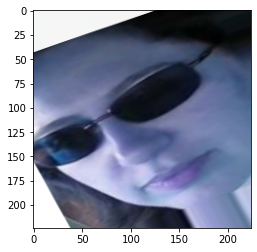

[0 1 0 0]


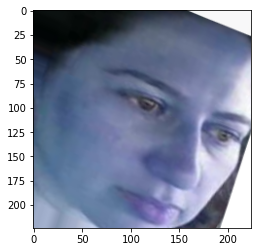

[1 0 0 0]


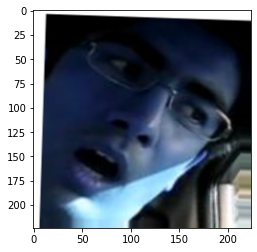

[0 1 0 0]


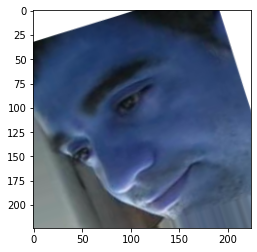

[0 0 0 1]


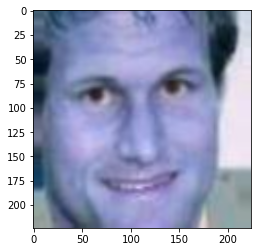

[0 0 1 0]


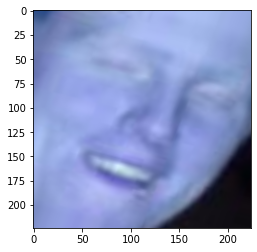

[0 0 1 0]


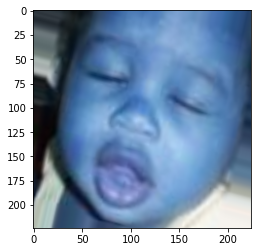

[0 0 0 1]


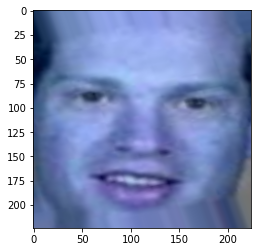

[0 0 1 0]


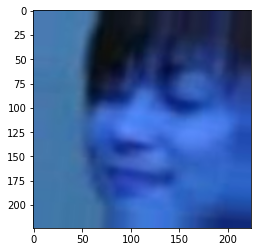

In [ ]:
train_images1,train_labels1 = train_generator.next()
for i in range(0,9):
    image = train_images1[i]
    label = train_labels1[i]
    print (label)
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

# Training Model Phase

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

In [ ]:
IMG_SHAPE = (224, 224, 3)

base_model=tf.keras.applications.MobileNetV3Small(
    input_shape=IMG_SHAPE,
    alpha=1.0,
    minimalistic=False,
    include_top=False,
    weights="imagenet",
    #dropout_rate=0.2,
    #classifier_activation="softmax",
    include_preprocessing=False,
)

base_model.trainable = False
x = base_model.output

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(base_model.input, x)
model.summary()



4334752/4334752 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 112, 112, 16  64         ['Conv[0][0]']                   
 tion)                         

In [ ]:

#Total params: 1,052,026
#Trainable params: 112,900
#Non-trainable params: 939,126

In [ ]:
optimizer1 = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name='Adam',
)
model.compile(loss="categorical_crossentropy",
              optimizer= optimizer1,
              metrics=["accuracy"])

In [ ]:
import time

start = time.time()
#model.fit() # Training statement
history = model.fit(train_generator, epochs=200,  shuffle=True, validation_data= (test_images_minmax, test_labels), validation_steps=len(test_images_minmax))
print("Total time: ", time.time() - start, "seconds")


Epoch 1/200
165/165 [==============================] - 73s 382ms/step - loss: 0.7309 - accuracy: 0.8364 - val_loss: 0.4174 - val_accuracy: 0.9128
Epoch 2/200
165/165 [==============================] - 60s 366ms/step - loss: 0.4880 - accuracy: 0.9095 - val_loss: 0.3723 - val_accuracy: 0.9305
Epoch 3/200
165/165 [==============================] - 61s 371ms/step - loss: 0.4350 - accuracy: 0.9269 - val_loss: 0.4877 - val_accuracy: 0.9221
Epoch 4/200
165/165 [==============================] - 60s 366ms/step - loss: 0.4158 - accuracy: 0.9387 - val_loss: 0.3784 - val_accuracy: 0.9363
Epoch 5/200
165/165 [==============================] - 60s 366ms/step - loss: 0.4011 - accuracy: 0.9413 - val_loss: 0.9704 - val_accuracy: 0.8774
Epoch 6/200
165/165 [==============================] - 60s 367ms/step - loss: 0.4431 - accuracy: 0.9438 - val_loss: 0.3254 - val_accuracy: 0.9482
Epoch 7/200
165/165 [==============================] - 60s 365ms/step - loss: 0.3691 - accuracy: 0.9499 - val_loss: 0.3319 -

#### Evaluation a model using Test dataset 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_images_minmax, test_labels, verbose=1)
print('Test accuracy :', test_accuracy)
print('Test loss :', test_loss)

print('Model accuracy is %.2f%% and Loss accuracy is %.2f%%' % (test_accuracy, test_loss))

71/71 [==============================] - 3s 26ms/step - loss: 0.2459 - accuracy: 0.9832
Test accuracy : 0.9831783771514893
Test loss : 0.24587176740169525
Model accuracy is 0.98% and Loss accuracy is 0.25%


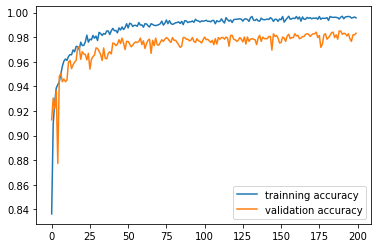

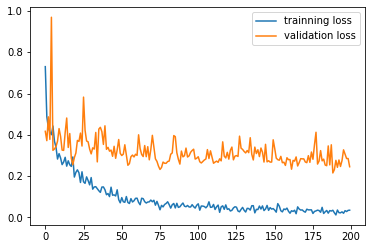

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(train_accuracy))

plt.plot(epochs, train_accuracy, label="trainning accuracy")
plt.plot(epochs, val_accuracy, label="validation accuracy")

plt.legend()
plt.show()

plt.plot(epochs, train_loss, label="trainning loss")
plt.plot(epochs, val_loss, label="validation loss")
plt.legend()
plt.show()

In [ ]:
prediction_model= model.predict(test_images_minmax, verbose=1)

prediction_classes_model = np.argmax(prediction_model, axis=1)
test_labels_prediction= np.argmax(test_labels, axis=1)


71/71 [==============================] - 2s 19ms/step


In [ ]:
labels_classes = ['Yawn', 'Non-Yawn', 'Closed-Eyes', 'Open-Eyes']

The result of the model using precision, recall and f1-score

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels_prediction, prediction_classes_model, target_names=labels_classes))

              precision    recall  f1-score   support

        Yawn       0.99      0.99      0.99       389
    Non-Yawn       1.00      0.99      1.00       551
 Closed-Eyes       0.98      0.97      0.97       626
   Open-Eyes       0.97      0.98      0.98       693

    accuracy                           0.98      2259
   macro avg       0.98      0.98      0.98      2259
weighted avg       0.98      0.98      0.98      2259



Plot the confusion_matrix

Confusion matrix, without normalization


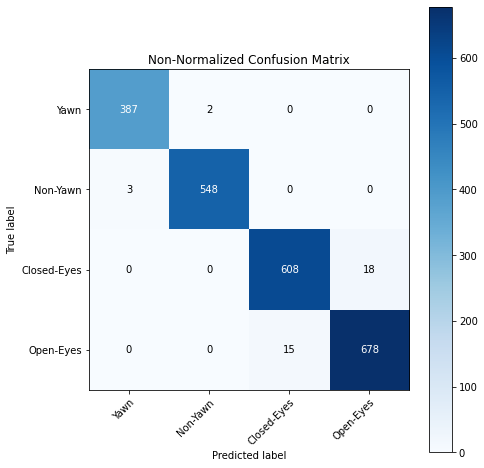

In [ ]:
from sklearn.metrics import confusion_matrix


#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(test_labels_prediction, prediction_classes_model)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

#Plotting the confusion matrix
confusion_mtx=confusion_matrix(test_labels_prediction, prediction_classes_model)

# Plotting non-normalized confusion matrix
plot_confusion_matrix(test_labels_prediction, prediction_classes_model, classes=labels_classes,
                      title='Non-Normalized Confusion Matrix')

Normalized confusion matrix


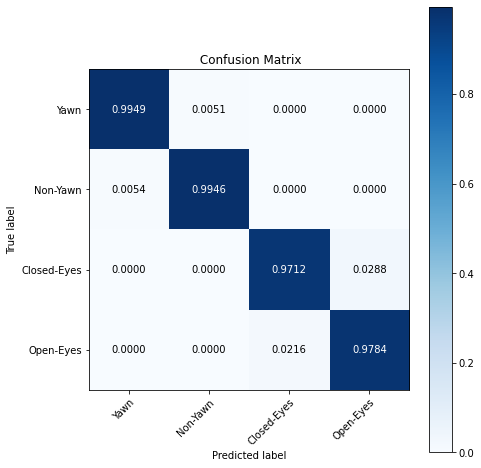

In [ ]:
# Plotting normalized confusion matrix
plot_confusion_matrix (test_labels_prediction, prediction_classes_model, classes= labels_classes, normalize=True, title=' Confusion Matrix')

# Define paths to model files


In [ ]:
MODELS_DIR = 'models1/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_TF2 = MODELS_DIR + 'model2.h5'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_QAWARE= MODELS_DIR + 'tflite_qaware_model.tflite'
MODEL_TFLITE = MODELS_DIR + 'model_tflite.tflite'
MODEL_TFLITE_PTQF = MODELS_DIR + 'model_tflite_PTQF.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model_tflite_micro.cc'

# Models Size

*get_file_size* function to know the size for all the models files

convert it to Megabytes, Kilobytes and bytes.

In [ ]:
#code for know the size of model from youtube
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

convert_bytes(get_file_size(MODEL_TF), "MB")

File size: 0.004 Megabytes


In [ ]:
# Calculate size
size_tf = os.path.getsize(MODEL_TF)
size_tf2 = os.path.getsize(MODEL_TF2)
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_PTQ = os.path.getsize(MODEL_TFLITE)
size_qaware = os.path.getsize(MODEL_QAWARE)
size_PTQF = os.path.getsize(MODEL_TFLITE_PTQF)


print ("size tf", size_tf)
print ("size tf", size_tf2)
print ("size tf", size_no_quant_tflite)
print ("size tf", size_qaware)
print ("size tf", size_PTQ)
print ("size tf", size_PTQF)


convert_bytes(get_file_size(MODEL_TF), "MB")
convert_bytes(get_file_size(MODEL_TF2), "MB")
convert_bytes(get_file_size(MODEL_NO_QUANT_TFLITE), "MB")
convert_bytes(get_file_size(MODEL_QAWARE), "MB")
convert_bytes(get_file_size(MODEL_TFLITE), "MB")
convert_bytes(get_file_size(MODEL_TFLITE_PTQF), "MB")


#3

# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow", f"{size_tf2} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_qaware} bytes", f"(reduced by {size_no_quant_tflite - size_qaware} bytes)"]],columns = ["Model", "Size", ""], index="Model")

size tf 4096
size tf 6243944
size tf 3707192
size tf 4183712
size tf 1221512
size tf 1329648
File size: 0.004 Megabytes
File size: 5.955 Megabytes
File size: 3.535 Megabytes
File size: 3.99 Megabytes
File size: 1.165 Megabytes
File size: 1.268 Megabytes


,Size,
Model,,
TensorFlow,4096 bytes,
TensorFlow,6243944 bytes,
TensorFlow Lite,3707192 bytes,(reduced by -3703096 bytes)
TensorFlow Lite Quantized,4183712 bytes,(reduced by -476520 bytes)


# Save Model

In [ ]:
model.save(MODEL_TF)

INFO:tensorflow:Assets written to: models1/model/assets


In [ ]:
model.save(MODEL_TF2)

# **Quantization-Aware-Training**

In [ ]:
! pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot


     |████████████████████████████████| 238 kB 5.0 MB/s 


In [ ]:
# Create a base model
base_model = model
 # optional but recommended for model accuracy
# Helper function uses `quantize_annotate_layer` to annotate that only the 
# Dense layers should be quantized.
def apply_quantization_to_dense(layer):
  if isinstance(layer, tf.keras.layers.Dense):
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer
print("a")
# Use `tf.keras.models.clone_model` to apply `apply_quantization_to_dense` 
# to the layers of the model.
annotated_model = tf.keras.models.clone_model(
    base_model,
    clone_function=apply_quantization_to_dense,
)
print("b")

# Now that the Dense layers are annotated,
# `quantize_apply` actually makes the model quantization aware.
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)

quant_aware_model.summary()

a
b
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 112, 112, 16  64         ['Conv[1][0]']                   
 tion)                          )                                                         

In [ ]:
optimizer1 = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name='Adam',
)
quant_aware_model.compile(loss="categorical_crossentropy",
              optimizer= optimizer1,
              metrics=["accuracy"])



In [ ]:
quant_aware_model.fit(train_generator, epochs=30,  shuffle=True, validation_data= (test_images_minmax, test_labels), validation_steps=len(test_images_minmax))

Epoch 1/30
165/165 [==============================] - 69s 400ms/step - loss: 0.0493 - accuracy: 0.9848 - val_loss: 0.2171 - val_accuracy: 0.9752
Epoch 2/30
165/165 [==============================] - 61s 371ms/step - loss: 0.1086 - accuracy: 0.9725 - val_loss: 0.2648 - val_accuracy: 0.9712
Epoch 3/30
165/165 [==============================] - 60s 363ms/step - loss: 0.0987 - accuracy: 0.9810 - val_loss: 0.2891 - val_accuracy: 0.9752
Epoch 4/30
165/165 [==============================] - 60s 363ms/step - loss: 0.1156 - accuracy: 0.9767 - val_loss: 0.2844 - val_accuracy: 0.9650
Epoch 5/30
165/165 [==============================] - 60s 363ms/step - loss: 0.0881 - accuracy: 0.9715 - val_loss: 0.4197 - val_accuracy: 0.9703
Epoch 6/30
165/165 [==============================] - 61s 367ms/step - loss: 0.1278 - accuracy: 0.9768 - val_loss: 0.3039 - val_accuracy: 0.9752
Epoch 7/30
165/165 [==============================] - 60s 363ms/step - loss: 0.1225 - accuracy: 0.9772 - val_loss: 0.5297 - val_ac

# **Convert and Optimize Model phase**

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_qaware_model = converter.convert()

# Save the model to disk
open(MODEL_QAWARE, "wb").write(tflite_qaware_model)
#quantize_model_len= len(tflite_qaware_model) /1024
#print ('QAT len is',quantize_model_len)
    
#with open("tflite_qaware_model.tflite", 'wb') as f:
 #   f.write(tflite_qaware_model)

INFO:tensorflow:Assets written to: /tmp/tmpi8c49i4e/assets
/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


4183712

# Running Model using Interpreter phase


Running inferences model using the TensorFlow Lite [`Interpreter`](https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter) for all images to compare the model accuracies between models

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)
#quantize_model_len= len(tflite_qaware_model) /1024
#print ('QAT len is',quantize_model_len)
    
#with open("tflite_qaware_model.tflite", 'wb') as f:
 #   f.write(tflite_qaware_model)

1221512

In [ ]:
import numpy as np
#test_labels = np.array(test_images_minmax , axis=0)

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(test_images_minmax):
    #if i % 1000 == 0:
     # print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == test_labels_prediction).mean()
  
  return accuracy

In [ ]:
#Interpreter QAT
interpreter = tf.lite.Interpreter(model_content=tflite_qaware_model)
interpreter.allocate_tensors()
start1=time.time()
test_accuracy = evaluate_model(interpreter)
print("total time", time.time()-start1, "second")


print('Quant test_accuracy:', test_accuracy)




total time 9.048272132873535 second
Quant test_accuracy: 0.9729969012837538


In [ ]:
#interpreter PTQ
interpreter = tf.lite.Interpreter(model_path=MODEL_TFLITE)
interpreter.allocate_tensors()
start = time.time()

test_accuracy = evaluate_model(interpreter)
print("Total time: ", time.time() - start, "seconds")
print('Quant TFLite test_accuracy:', test_accuracy)




Total time:  15.694650888442993 seconds
Quant TFLite test_accuracy: 0.9698981850376273


#Full Integer Quantization 

In [ ]:
test_images_minmax = np.array(test_images_minmax, dtype=np.float32)
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(test_images_minmax).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

model_tflite_PTQF = converter.convert()

# Save the Quantize model
open(MODEL_TFLITE_PTQF, "wb").write(model_tflite_PTQF)

INFO:tensorflow:Assets written to: /tmp/tmpkdoirybv/assets
/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


1329648

Running Interpreter 
for Full Integer Quantization 

In [ ]:
def evaluate_model_PTQF(interpreter):
  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  predictions = np.zeros((len(test_images_minmax),), dtype=int)

  for i, test_image in enumerate(test_images_minmax):
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point


    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_details["index"])
    digit = np.argmax(output()[0])
    predictions [i]= digit
    
    print('\n')
   # Compare prediction results with ground truth labels to calculate accuracy.
  accuracy = (predictions == test_labels_prediction).mean()
  return accuracy

In [ ]:
interpreter = tf.lite.Interpreter(model_path=MODEL_TFLITE_PTQF)

start2=time.time()
interpreter.allocate_tensors()

#Evaluate Quantizaed Model using **accuracy**
test_accuracy = evaluate_model_PTQF(interpreter)
print("total time", time.time()-start2,"second")
print('Quant TFLite test_accuracy:', test_accuracy)


In [ ]:


#total time 23.49218773841858 second
#Quant TFLite test_accuracy: 0.687228496959166

In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler	

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2426  100  2426    0     0   118k      0 --:--:-- --:--:-- --:--:--  118k
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,722 B]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 https://developer.download.

In [ ]:
import os
from google.colab import files

name = os.path.splitext(os.environ['MODEL_TFLITE'])[0]
files.download(str(name + 'model_tflite.tflite'))

KeyError: ignored

In [ ]:
!edgetpu_compiler tflite_qaware_model.tflite

In [ ]:
MODELS_DIR = 'models1/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_TF2 = MODELS_DIR + 'model2.h5'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_QAWARE= MODELS_DIR + 'tflite_qaware_model.tflite'
MODEL_TFLITE = MODELS_DIR + 'model_tflite.tflite'
MODEL_TFLITE_PTQF = MODELS_DIR + 'model_tflite_PTQF.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model_tflite_micro.cc'

In [ ]:
!edgetpu_compiler $MODEL_TFLITE

#Running Interpreter phase 


In [ ]:
interpreter = tf.lite.Interpreter(model_path = MODEL_TFLITE)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("input_details", input_details)
print("output_details", output_details)

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

interpreter.resize_tensor_input(input_details[0]['index'], (2259, 224, 224,3))
interpreter.resize_tensor_input(output_details[0]['index'], (2259, 4))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("input_details", input_details)
print("output_details", output_details)

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

In [ ]:
test_imgs_numpy = np.array(test_images_minmax, dtype=np.float32)

interpreter.set_tensor(input_details[0]['index'], test_imgs_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions)
prediction_classes_tflite_model = np.argmax(tflite_model_predictions, axis=1)
print("tflite_model_predictions",prediction_classes_tflite_model)

In [ ]:
from sklearn.metrics import accuracy_score
acc= accuracy_score(prediction_classes_tflite_model, np.argmax(test_labels, axis=1))
print("Test accuracy of TFLITE model :",acc)


####**Prediction using Quantized model and visulize the outputs**

In [ ]:
# Utilities for plotting

class_names = ["Yawn", "Non_Yawn", "Closed-Eyes", "Open-Eyes"]

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

In [ ]:
# Visualize the outputs { run: "auto" }
max_index = 99 #@param {type:"slider", min:0, max:99, step:1}
y_test_inter=np.argmax(test_labels, axis=1)

for index in range(0,max_index):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(index, tflite_model_predictions, test_labels_prediction, test_imgs_numpy)
  plt.show()

# Convert Model to C array phase

In [ ]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_QAWARE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_QAWARE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

In [ ]:
# Print the C source file
!cat {MODEL_TFLITE_MICRO}